In [52]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt

import IPython.display as ipd
import seaborn as sns

import warnings
import os

import torch
from torch import nn, optim
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

In [53]:
audio_features = pd.read_csv('/home/arpitsah/Desktop/Projects Fall-22/DA/domain_adaptation/LSTM-DENSE/speech-emotion-recognition-iemocap/preprocess_info/audio_features.csv')

In [54]:
audio_features.head()

,wav_file,label,flatness,zerocr,meancent,stdcent,maxcent,pitchmean,pitchmax,pitchmin,...,mel126,mel127,mel128,contrast1,contrast2,contrast3,contrast4,contrast5,contrast6,contrast7
0,Ses01M_script01_2_F000,0,0.000240,0.055343,0.008130,0.001714,0.014044,36.543182,177.455444,0.0,...,1.308270e-10,1.263389e-10,1.235865e-10,17.239212,13.941932,14.874545,14.849185,16.230488,17.757777,57.287688
1,Ses01M_script01_2_F001,0,0.000177,0.049172,0.005102,0.001404,0.012810,68.735916,155.426529,0.0,...,2.936848e-11,2.863149e-11,2.817110e-11,16.649447,12.375123,14.778021,14.914547,16.769379,16.838275,58.822633
2,Ses01M_script01_2_F002,8,0.000250,0.060826,0.008547,0.001922,0.016922,80.757545,274.377533,0.0,...,1.500557e-10,1.469233e-10,1.449430e-10,15.968722,13.303472,15.370515,14.653921,17.685535,16.651051,58.517737
3,Ses01M_script01_2_F003,8,0.000221,0.066547,0.008475,0.002963,0.024325,46.886211,177.291580,0.0,...,1.028152e-09,1.012797e-09,1.002813e-09,15.986299,12.234666,14.501920,14.767501,16.860734,17.900835,57.929539
4,Ses01M_script01_2_F004,0,0.000159,0.071784,0.006579,0.001990,0.017874,10.885402,102.002754,0.0,...,2.732974e-11,2.673165e-11,2.635169e-11,17.397841,14.855312,16.196001,16.824510,17.497636,19.738831,55.205751


In [55]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8,
                'dis': 8}

In [56]:
audio_features.label.value_counts()

8    2026
4    1473
7    1329
0     936
3     869
2     806
1     454
6      91
5      30
Name: label, dtype: int64

In [57]:
audio_4emotions = audio_features[audio_features["label"].isin([0, 1, 3, 7])]

In [58]:
audio_4emotions.shape

(3588, 201)

In [59]:
def emotion(x):
    if x == 0:
        return "angry"
    elif x == 1:
        return "happy"
    elif x == 3:
        return "sadness"
    else:
        return 'neutral'

In [60]:
audio_4emotions["emotion"] = audio_4emotions["label"].apply(emotion)

In [61]:
def label_new(x):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif x == 3:
        return 2
    else:
        return 3

In [62]:
audio_4emotions["label"] = audio_4emotions["label"].apply(label_new)

In [63]:
audio_4emotions["label"].value_counts()

3    1329
0     936
2     869
1     454
Name: label, dtype: int64

In [64]:
audio_4emotions.head()

,wav_file,label,flatness,zerocr,meancent,stdcent,maxcent,pitchmean,pitchmax,pitchmin,...,mel127,mel128,contrast1,contrast2,contrast3,contrast4,contrast5,contrast6,contrast7,emotion
0,Ses01M_script01_2_F000,0,0.000240,0.055343,0.008130,0.001714,0.014044,36.543182,177.455444,0.0,...,1.263389e-10,1.235865e-10,17.239212,13.941932,14.874545,14.849185,16.230488,17.757777,57.287688,angry
1,Ses01M_script01_2_F001,0,0.000177,0.049172,0.005102,0.001404,0.012810,68.735916,155.426529,0.0,...,2.863149e-11,2.817110e-11,16.649447,12.375123,14.778021,14.914547,16.769379,16.838275,58.822633,angry
4,Ses01M_script01_2_F004,0,0.000159,0.071784,0.006579,0.001990,0.017874,10.885402,102.002754,0.0,...,2.673165e-11,2.635169e-11,17.397841,14.855312,16.196001,16.824510,17.497636,19.738831,55.205751,angry
5,Ses01M_script01_2_F005,0,0.000197,0.098830,0.002747,0.000960,0.007159,15.153377,101.897003,0.0,...,1.131963e-08,1.111381e-08,14.318142,16.569613,19.012398,16.803689,18.371521,19.161257,58.707505,angry
9,Ses01M_script01_2_F009,0,0.000130,0.071346,0.001704,0.000633,0.004604,8.757346,134.542175,0.0,...,1.125818e-11,1.116775e-11,16.525942,15.347263,16.921631,15.839474,17.357330,18.459367,52.495735,angry


In [65]:
audio_4emotions.columns.get_loc("emotion")

201

In [66]:
train_raw = audio_4emotions.iloc[:, 2:201]

In [67]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(train_raw)
train_scaled = pd.DataFrame(scaled)
train_scaled.columns = train_raw.columns
train_scaled.head()

,flatness,zerocr,meancent,stdcent,maxcent,pitchmean,pitchmax,pitchmin,pitchstd,pitch_tuning_offset,...,mel126,mel127,mel128,contrast1,contrast2,contrast3,contrast4,contrast5,contrast6,contrast7
0,0.115663,0.162883,0.240805,0.096425,0.182149,0.211254,0.439522,0.0,0.372568,0.404040,...,1.836009e-06,1.811076e-06,1.795984e-06,0.512331,0.301199,0.207383,0.211420,0.214275,0.210560,0.539301
1,0.080613,0.127624,0.141372,0.075476,0.163086,0.397358,0.384960,0.0,0.393772,0.191919,...,4.120602e-07,4.103606e-07,4.093246e-07,0.460097,0.161483,0.198829,0.218364,0.296429,0.123045,0.626767
2,0.070928,0.256826,0.189870,0.115045,0.241298,0.062928,0.252640,0.0,0.161979,0.191919,...,3.834468e-07,3.831249e-07,3.828833e-07,0.526381,0.382648,0.324490,0.421281,0.407452,0.399111,0.420664
3,0.092065,0.411366,0.064047,0.045455,0.075815,0.087601,0.252379,0.0,0.185685,0.808081,...,1.635418e-04,1.622759e-04,1.615154e-04,0.253617,0.535517,0.574078,0.419068,0.540675,0.344139,0.620207
4,0.054843,0.254328,0.029776,0.023412,0.036345,0.050626,0.333234,0.0,0.170958,0.777778,...,1.597571e-07,1.613001e-07,1.622171e-07,0.449158,0.426517,0.388795,0.316629,0.386062,0.277335,0.266238


In [68]:
train = train_scaled.values.astype(np.float32)
target = audio_4emotions.iloc[:, 1].values

In [69]:
torch.cuda.is_available()

True

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify=target, test_size=0.2)

In [72]:
len(X_train)

2870

In [73]:
Counter(y_train)

Counter({3: 1063, 0: 749, 1: 363, 2: 695})

In [74]:
Counter(y_test)

Counter({2: 174, 0: 187, 3: 266, 1: 91})

In [75]:
batch_size = 128

In [76]:
class AudioDataset_train(Dataset):
    """
    Diabetes Dataset
    """
    
    def __init__(self):
        self.len = len(X_train)
        self.x_data = torch.from_numpy(X_train)
        self.y_data = torch.from_numpy(y_train)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
traindataset = AudioDataset_train()

trainloader = DataLoader(dataset=traindataset,
                          batch_size=batch_size,
                          shuffle=True)

In [77]:
class AudioDataset_test(Dataset):
    """
    Diabetes Dataset
    """
    
    def __init__(self):
        self.len = len(X_test)
        self.x_data = torch.from_numpy(X_test)
        self.y_data = torch.from_numpy(y_test)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
testdataset = AudioDataset_test()

testloader = DataLoader(dataset=testdataset,
                          batch_size=batch_size)

In [78]:
len(testloader)

6

In [79]:
testiter = iter(testloader)
features, labels = next(testiter)
features.shape, labels.shape

(torch.Size([128, 199]), torch.Size([128]))

In [80]:
features.type()

'torch.FloatTensor'

In [125]:
class Net(nn.Module):
    
    
    def __init__(self):
        
        super(Net, self).__init__()
        self.l1 = nn.Linear(199, 300)
#         self.l2 = nn.Linear(200, 100)
#         self.l3 = nn.Linear(100, 50)
#         self.l4 = nn.Linear(50, 4)
        
        self.l5 = nn.Linear(300, 4)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x): # flattening (n, 1, 28, 28)--> (n, 784)
        x = F.relu(self.l1(x))
#         x = F.relu(self.l2(x))
#         x = self.dropout(x)
#         x = F.relu(self.l3(x))
        x = self.dropout(x)
        return F.softmax(self.l5(x))
        
        
# intantiation

net = Net()

In [88]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

1.13.1+cu116
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 28.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.8 MB/s eta 0:00:0000:0100:01


In [152]:
# With Affine Layer
import torch.nn as nn
from sparselinear import SparseLinear
class Net(nn.Module):
    
    
    def __init__(self):
        
        super(Net, self).__init__()#128*199
        self.l1 = nn.Linear(199, 200)
        self.l2 = nn.Linear(200, 100)
        self.l3 = nn.Linear(100, 50)
#         self.l4 = nn.Linear(50, 4)
        self.sparse = SparseLinear(50, 50,sparsity =1- float(1/50))# replace with sparse 
        self.l5 = nn.Linear(50, 4) 
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x): # flattening (n, 1, 28, 28)--> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.sparse(x)

        x = self.dropout(x)
        return F.softmax(self.l5(x))
        
# instantiation

net = Net()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)     

print("network before turning off sparse layer", count_parameters(net))

for param in net.sparse.parameters():
    param.requires_grad = False     


print("network after turning off sparse layer", count_parameters(net))



network before turning off sparse layer 65454
network after turning off sparse layer 65354


In [153]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [154]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [155]:
print("anger {} happiness {} neutral {} sadness {}".format(anger, happiness, neutral, sadness))

anger 936 happiness 454 neutral 869 sadness 1329


In [156]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cuda()
class_weights

tensor([0.0011, 0.0022, 0.0012, 0.0008], device='cuda:0')

In [157]:
label_to_class = {0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [158]:
final_labels = ['anger', 'happiness', 'neutral', 'sadness']

In [159]:
# instantiation
model = Net()
print("network after turning off sparse layer", count_parameters(net))

network after turning off sparse layer 65354


In [160]:
model.to(device)

Net(
  (l1): Linear(in_features=199, out_features=200, bias=True)
  (l2): Linear(in_features=200, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=50, bias=True)
  (sparse): SparseLinear(in_features=50, out_features=50, bias=True, sparsity=0.98, connectivity=None, small_world=False)
  (l5): Linear(in_features=50, out_features=4, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [161]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [162]:
# optimizer and criterion
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.003)
optimizer = optim.Adam(model.parameters(), lr=0.003)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [163]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        print(data.shape)
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())
            

In [164]:
from sklearn.metrics import confusion_matrix
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    confusion_matrix(actual_with_label, pred_with_label, labels=final_labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

In [165]:
history = []
n_epoch = 101
for epoch in range(1, n_epoch):
#     exp_lr_scheduler.step(epoch)
    # import pdb
    # pdb.set_trace()
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

torch.Size([128, 199])
Train Epoch: 1 [0/2870 (0%)]	Loss: 1.390126

torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
Train Epoch: 1 [1280/2870 (43%)]	Loss: 1.385369

torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
torch.Size([128, 199])
Train Epoch: 1 [2560/2870 (87%)]	Loss: 1.357037

torch.Size([128, 199])
torch.Size([54, 199])

Train set: Average loss: 0.0110


Train Accuracy: 970/2870 (34%)


Test set: Average loss: 0.0111, Accuracy: 311/718 (43%)


 Classification Report 
               precision    recall  f1-score   support

       anger       0.39      0.95      0.55       187
   happiness       0.00      0.00      0.00        91
     neutral   

In [166]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [167]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [168]:
history_df

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.011017,33,0.011062,43,1
1,0.010395,42,0.010450,47,2
2,0.010113,48,0.010275,53,3
3,0.009979,47,0.010114,56,4
4,0.009883,51,0.010097,54,5
...,...,...,...,...,...
95,0.008991,61,0.009468,59,96
96,0.008922,61,0.009531,57,97
97,0.008988,60,0.009470,61,98
98,0.009052,60,0.009601,63,99


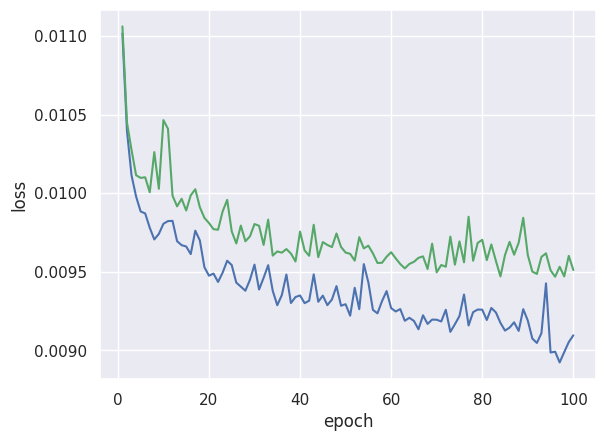

In [169]:
sns.set()
sns.lineplot(x='epoch', y='train_loss', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_loss', data=history_df, color='g')
plt.ylabel("loss")
plt.show()

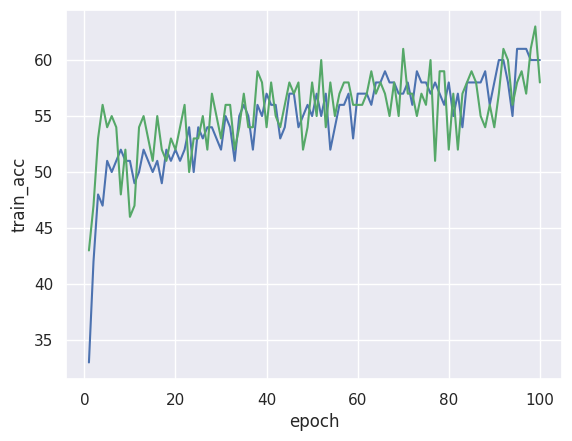

In [170]:
sns.set()
sns.lineplot(x='epoch', y='train_acc', data=history_df, color='b')
# plt.xticks(history_df.epoch)
sns.lineplot(x='epoch', y='test_acc', data=history_df, color='g')
plt.show()